In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd /content/gdrive/My Drive/Вышечка/4 курс/нейросети

/content/gdrive/My Drive/Вышечка/4 курс/нейросети


In [ ]:
!unzip 'processed_corpus.json.zip' 

Archive:  processed_corpus.json.zip
  inflating: processed_corpus.json   


In [6]:
with open('data/processed_corpus.json') as f:
    corpus = json.load(f)

In [7]:
len(corpus)

100000

In [8]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [9]:
sample_text = corpus[1]

In [10]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [11]:
# пробовала на том же тексте, какой и был изначально в тетрадке

sample_text = ['вопрос', 'почему', 'например', 'китайский', 'японский', 'UNK']

In [12]:
def cbow_split(tokens, window, pad_token='PAD'):
    splits = []
    
    for ind, token in enumerate(tokens):
        
        left = []
        # если слово первое - перед ним ставит "нулевой левый контекств"
        if ind <= window - 1 and ind == 0:
            for el in range(window):
                left.append(pad_token)
        # если слово не первое, но часть левого контекста - "нулевая"
        elif ind <= window - 1 and ind != 0:
            if len(tokens[:ind]) <= window:
                # пустое 
                for el in range(window-len(tokens[:ind])):
                    left.append(pad_token)
                # слово
                for w in tokens[:ind]:
                    left.append(w)
        # все остальное
        else:
            for words in tokens[ind-window:ind]:
                left.append(words)

        cent = token
        
        right = []
        # для последнего слова в правом контексте все будет "нулевым"
        if ind >= window - 1 and ind == len(tokens) - 1:
            for el in range(window):
                right.append(pad_token)
        else:
            if len(tokens[ind:]) <= window:
                for w in tokens[ind+1:]:
                    right.append(w)
                for el in range(-(len(tokens[ind+1:])-window)):
                    right.append(pad_token)
            # если слово внутри текста
            else:
                for words in tokens[ind+1:ind+window+1]:
                    right.append(words)
    
        splits.append((left, cent, right))

    return splits

In [13]:
splits = cbow_split(sample_text, window=2)

In [14]:
splits

[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

In [15]:
# что получилось у меня
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вопрос
Правый контекст: ['почему', 'например']

Левый контекст: ['PAD', 'вопрос']
Центральное слово: почему
Правый контекст: ['например', 'китайский']

Левый контекст: ['вопрос', 'почему']
Центральное слово: например
Правый контекст: ['китайский', 'японский']

Левый контекст: ['почему', 'например']
Центральное слово: китайский
Правый контекст: ['японский', 'UNK']

Левый контекст: ['например', 'китайский']
Центральное слово: японский
Правый контекст: ['UNK', 'PAD']

Левый контекст: ['китайский', 'японский']
Центральное слово: UNK
Правый контекст: ['PAD', 'PAD']



In [ ]:
# что было в тетрадке
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вопрос
Правый контекст: ['почему', 'например']

Левый контекст: ['PAD', 'вопрос']
Центральное слово: почему
Правый контекст: ['например', 'китайский']

Левый контекст: ['вопрос', 'почему']
Центральное слово: например
Правый контекст: ['китайский', 'японский']

Левый контекст: ['почему', 'например']
Центральное слово: китайский
Правый контекст: ['японский', 'UNK']

Левый контекст: ['например', 'китайский']
Центральное слово: японский
Правый контекст: ['UNK', 'PAD']

Левый контекст: ['китайский', 'японский']
Центральное слово: UNK
Правый контекст: ['PAD', 'PAD']



In [ ]:
splits

[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [16]:
# что получилось у меня
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

In [ ]:
# что было в тетрадке
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [17]:
' '.join(sample_text)

'вопрос почему например китайский японский UNK'

# Реализуйте разделение предложения на примеры методом Skipgram

In [18]:
def skipgram_split(tokens, window):
    splits = []
    # CODE
    for ind, token in enumerate(tokens):
        first = ind-window  # индекс первого элменента
        last = ind + 1 + window  # индекс второго элменета

        # ограничиваем
        if last >= len(tokens):
            last = len(tokens)
        if first <= 0:
            first = 0
        
        word = token
        
        all_context = tokens[first:last]
        for con in all_context:
            if con != word:
                splits.append((con, word))

    return splits

In [19]:
splits = skipgram_split(sample_text, window=2)

In [20]:
splits

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

In [21]:
# что получилось у меня
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: почему
Центральное слово: вопрос

Контекст: например
Центральное слово: вопрос

Контекст: вопрос
Центральное слово: почему

Контекст: например
Центральное слово: почему

Контекст: китайский
Центральное слово: почему

Контекст: вопрос
Центральное слово: например

Контекст: почему
Центральное слово: например

Контекст: китайский
Центральное слово: например

Контекст: японский
Центральное слово: например

Контекст: почему
Центральное слово: китайский

Контекст: например
Центральное слово: китайский

Контекст: японский
Центральное слово: китайский

Контекст: UNK
Центральное слово: китайский

Контекст: например
Центральное слово: японский

Контекст: китайский
Центральное слово: японский

Контекст: UNK
Центральное слово: японский

Контекст: китайский
Центральное слово: UNK

Контекст: японский
Центральное слово: UNK



In [ ]:
# что было в тетрадке
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: почему
Центральное слово: вопрос

Контекст: например
Центральное слово: вопрос

Контекст: вопрос
Центральное слово: почему

Контекст: например
Центральное слово: почему

Контекст: китайский
Центральное слово: почему

Контекст: вопрос
Центральное слово: например

Контекст: почему
Центральное слово: например

Контекст: китайский
Центральное слово: например

Контекст: японский
Центральное слово: например

Контекст: почему
Центральное слово: китайский

Контекст: например
Центральное слово: китайский

Контекст: японский
Центральное слово: китайский

Контекст: UNK
Центральное слово: китайский

Контекст: например
Центральное слово: японский

Контекст: китайский
Центральное слово: японский

Контекст: UNK
Центральное слово: японский

Контекст: китайский
Центральное слово: UNK

Контекст: японский
Центральное слово: UNK



In [ ]:
skipgram_split(sample_text, window=2)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [22]:
# что получилось у меня

skipgram_split(sample_text, window=3)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

In [ ]:
# что было в тетрадке

skipgram_split(sample_text, window=3)

[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [23]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [24]:
len(word2index)

13076

In [25]:
word2index['UNK']

1

In [26]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [27]:
from torch.utils.data import Dataset, DataLoader

In [28]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [29]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.98436579, 0.05528267, 0.52126436, 0.28528767],
       [0.18876065, 0.27818151, 0.66652937, 0.56151448],
       [0.51722962, 0.06421964, 0.65732017, 0.98057357],
       [0.17698109, 0.5934018 , 0.70920224, 0.88227791],
       [0.52259552, 0.44075652, 0.7946476 , 0.44782343],
       [0.67624196, 0.83297924, 0.64508758, 0.88134555],
       [0.63765316, 0.15840651, 0.20428626, 0.78014329],
       [0.98327604, 0.66066285, 0.45297603, 0.37820242],
       [0.55958496, 0.39994721, 0.5210758 , 0.68490581],
       [0.1095419 , 0.00667649, 0.47835374, 0.94863121]])

In [30]:
some_data_y

array([1, 0, 1, ..., 1, 2, 2])

In [31]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [32]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [33]:
some_dataset[5], some_dataset[467]

((array([0.67624196, 0.83297924, 0.64508758, 0.88134555]), 0),
 (array([0.60735757, 0.76957689, 0.94328381, 0.37123129]), 1))

In [34]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [35]:
for x, y in some_loader:
    break
    
len(x), x

(16, tensor([[0.5360, 0.1511, 0.2582, 0.2946],
         [0.7162, 0.7098, 0.6680, 0.0281],
         [0.4901, 0.8009, 0.9833, 0.8476],
         [0.6254, 0.2744, 0.0850, 0.4913],
         [0.8887, 0.2376, 0.0075, 0.0689],
         [0.2497, 0.8221, 0.8228, 0.9270],
         [0.0239, 0.3376, 0.6284, 0.8196],
         [0.0147, 0.6827, 0.0767, 0.9583],
         [0.4213, 0.5668, 0.4249, 0.4065],
         [0.0435, 0.6533, 0.8771, 0.4622],
         [0.9347, 0.5314, 0.3419, 0.4564],
         [0.7662, 0.3021, 0.0228, 0.6700],
         [0.3266, 0.6676, 0.1586, 0.8827],
         [0.8873, 0.8602, 0.5313, 0.7894],
         [0.1077, 0.8723, 0.2178, 0.0181],
         [0.3817, 0.3602, 0.7823, 0.1934]], dtype=torch.float64))

In [36]:
for x, y in some_loader:
    pass

len(x)

15

In [37]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [38]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [39]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [40]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [41]:
for x, y in toy_loader:
    break

In [42]:
x.shape

torch.Size([128, 32])

In [43]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.9844,   0.0553,   0.5213,  ..., -17.3718,  -3.9090,  -7.5255],
        [  0.1888,   0.2782,   0.6665,  ...,  -7.6769,  -2.4340,  -3.4627],
        [  0.5172,   0.0642,   0.6573,  ..., -16.4727,  -2.5175,  -0.1177],
        ...,
        [  0.8748,   0.0805,   0.0761,  ..., -15.1173, -15.4563,  -0.5032],
        [  0.0733,   0.7335,   0.2958,  ...,  -1.8597,  -7.3079,  -1.7337],
        [  0.6799,   0.9691,   0.1349,  ...,  -0.1883, -12.0197, -10.8588]],
       dtype=torch.float64)

In [44]:
y

tensor([1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 1, 2, 2, 2, 0, 2, 0, 1, 0, 1,
        1, 2, 0, 1, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 1, 0, 0, 0, 2, 0,
        0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1,
        0, 0, 1, 1, 2, 1, 0, 2, 2, 1, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 1, 2, 2, 1,
        0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 0,
        1, 2, 2, 1, 2, 1, 0, 1])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [45]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [46]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.2072337865829468

# Боевые датасеты

In [47]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [48]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()
        # pass

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше

        splits = []

        tokens = tokenized_text

        for ind, token in enumerate(tokens):
            first = ind - self.window  # индекс первого элменента
            last = ind + 1 + self.window  # индекс второго элменета

            # ограничиваем
            if last >= len(tokens):
                last = len(tokens)
            if first <= 0:
                first = 0
            
            word = token
            
            all_context = tokens[first:last]
            for con in all_context:
                if con != word:
                    splits.append((con, word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        
        context, central_word = self.data[idx]
        # print(context, central_word)

        return context, central_word

In [ ]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [49]:
dataset = SkipgramDataset(corpus, word2index)

100%|██████████| 100000/100000 [00:01<00:00, 65935.64it/s]


In [50]:
BATCH_SIZE = 512

In [51]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [52]:
for x, y in dataset_loader:
    break

In [53]:
x[:5]

tensor([5089,   25,   60,   32,   94])

In [54]:
y[:5]

tensor([  52,  899,  608, 1619,   95])

In [55]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [56]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [57]:
# CODE
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        # тут мы убираем сумму, иначе это вернет не ту размерность, в отличе от cbow
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [ ]:
#from word2vec_utils import SkipGram

In [58]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [59]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [60]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [61]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [62]:
epochs = 3

losses = []


# взяла все, по сути, из первой домашки


for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # # CODE

            # optimizer.zero_grad()

            pred = model(x)
        
            loss = criterion(pred, y)
            
            loss.backward()

            optimizer.step()

            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))
            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████| 2967206/2967206 [07:15<00:00, 6815.83it/s, loss=7.14]


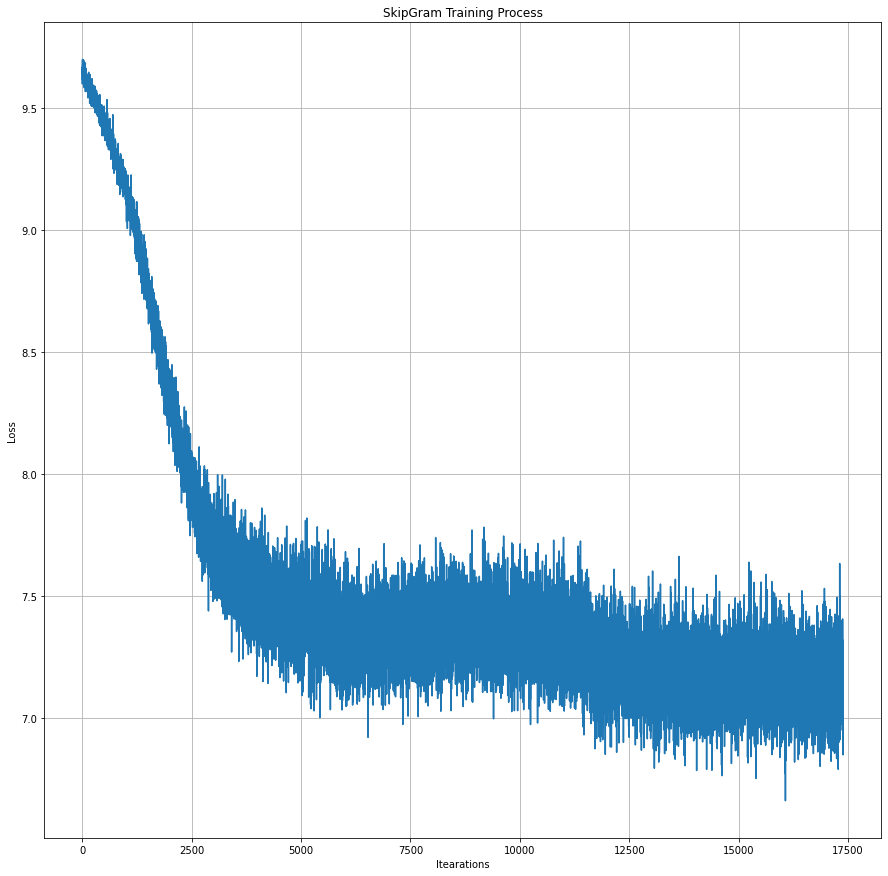

In [63]:
# что получилось у меня
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

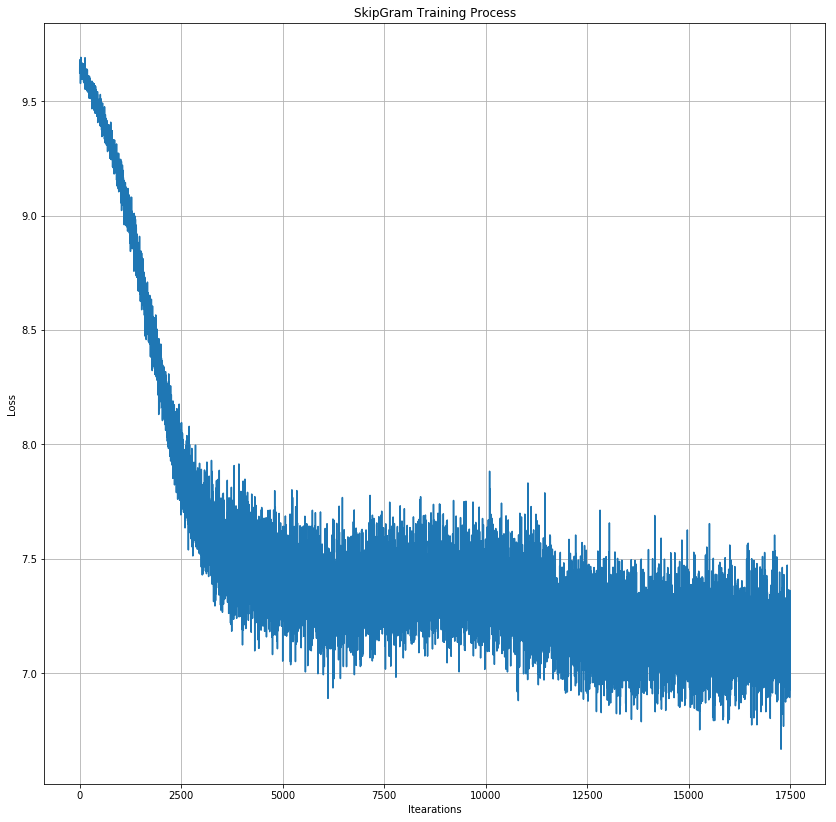

In [ ]:
# что было в тетрадке
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [64]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [65]:
embedding_matrix = model.in_embedding.weight.detach()

In [66]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [67]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.8866924047470093

In [68]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.6872444152832031

In [69]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.753935694694519

In [70]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6117944717407227

In [71]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "процессинг" равна 0.430'

In [72]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [73]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [74]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.037s...
[t-SNE] Computed neighbors for 13076 samples in 9.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sam

In [75]:
top_words = [a for a,_ in top_sorted_freq]

In [76]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

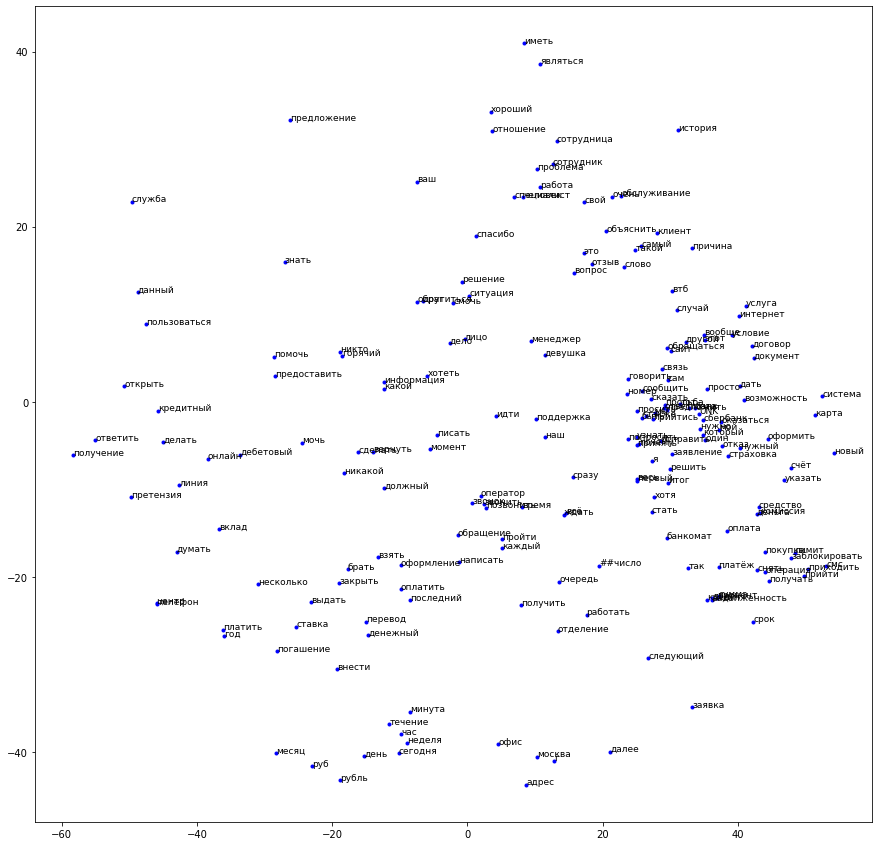

In [77]:
# то, что получилось у меня
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

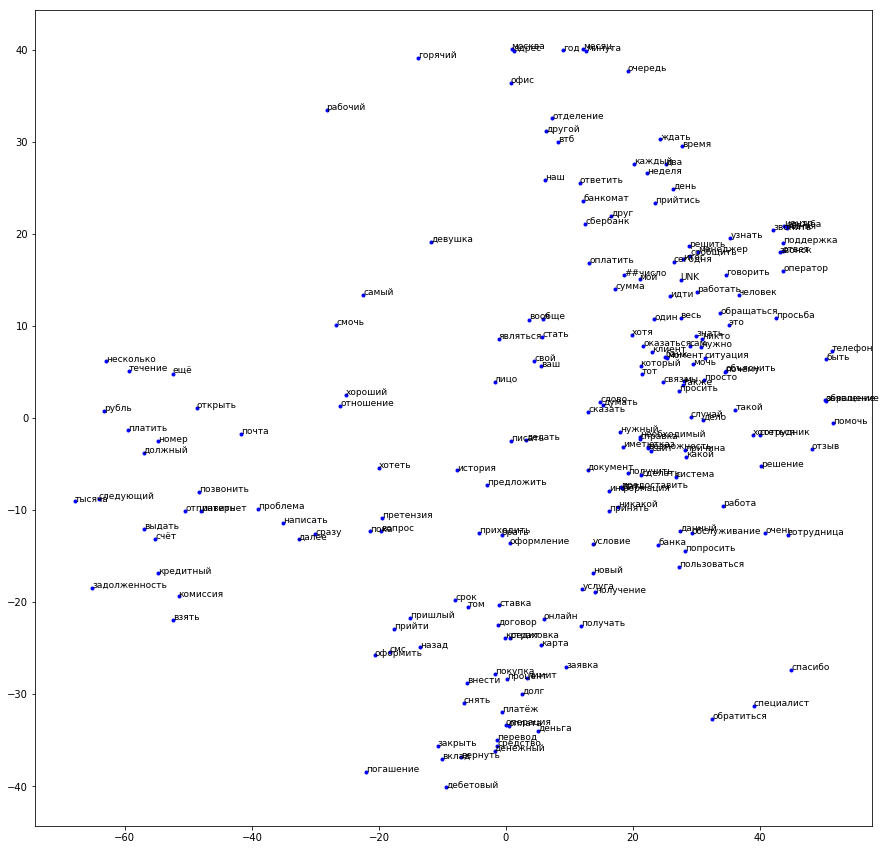

In [ ]:
# то, что было в тетрадке
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()